# Restricted Boltzmann Machine Defintion

In [1]:
# TODO g = 1 + ap of g = ap

In [2]:
# Import PyTorch library
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, flatten, device
from tqdm import tqdm, trange

In [3]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [4]:
# https://github.com/khanhnamle1994/MetaRec/blob/b5e36cb579a88b32cdfb728f35f645d76b24ad95/Boltzmann-Machines-Experiments/RBM-CF-PyTorch/rbm.py#L23
# Create the Restricted Boltzmann Machine architecture
class network(nn.Module):
    def __init__(self, x ):
        super().__init__()
        
    #use 4 layers and fc layer

        self.dropout = nn.Dropout(0.25)
        if torch.cuda.is_available():
            self.device = device("cuda")

        self.conv1 = nn.Linear(x, 20).to(self.device)
        self.conv2 = nn.Linear(20, 50).to(self.device)
        self.conv3 = nn.Linear(50, 20).to(self.device)
        self.fc = nn.Linear(20, x).to(self.device)

    def forward(self, x):
        if torch.cuda.is_available():
            x = x.to(self.device)

        x = F.relu(self.conv1(x))

        # x = F.max_pool1d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # x = flatten(x, 1)

        x = self.dropout(x)
        output = self.fc(x)
        # output = F.softmax(x, dim=1)
        return output
    

In [5]:
cuda = torch.device('cuda')

# General Imports

In [6]:
import numpy as np
import pickle as pickle
import pandas as pd
import scipy
import sklearn
import gzip
import json
from tqdm import tqdm
import os
from collections import Counter
from datetime import datetime
import math
tqdm.pandas() #for progres_apply etc.

# Reading

In [7]:
def load_interactions(path, n_splits=5):
    df = pd.read_pickle(os.path.join(os.getcwd(), path))
    df[['interactions', 'train', 'val', 'test']] = df[['interactions', 'train', 'val', 'test']].applymap(lambda x: np.array(x, dtype=np.int32))
    interactions_dict = {}
    for split in trange(n_splits):
        for column in ['train', 'val', 'test']:
            interactions_dict[split, column] = pd.DataFrame({
                'user_id': df['user_id'],
                'steam_id': df['steam_id'],
                'item_id': df[column].apply(lambda x: x[split, 0]),
                'playtime_forever': df[column].apply(lambda x: x[split, 1]),
                'playtime_2weeks': df[column].apply(lambda x: x[split, 2])})
    return interactions_dict

In [8]:
interactions = load_interactions("./data-cleaned/interactions_splits.pkl.gz")
interactions[0, 'train'].head()
games = pd.read_pickle(os.path.join(os.getcwd(), "./data-cleaned/games.pkl.gz"))
games.head()

100%|██████████| 5/5 [00:00<00:00,  7.10it/s]


,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore,users_count
0,Valve,[Action],Counter-Strike: Global Offensive,Counter-Strike: Global Offensive,http://store.steampowered.com/app/730/CounterS...,2012-08-21,"[FPS, Multiplayer, Shooter, Action, Team-Based...",NaN,http://steamcommunity.com/app/730/reviews/?bro...,"[Multi-player, Steam Achievements, Full contro...",14.99,False,730,Valve,Very Positive,83,42618
1,Valve,"[Indie, Simulation]",Garry's Mod,Garry's Mod,http://store.steampowered.com/app/4000/Garrys_...,2006-11-29,"[Sandbox, Multiplayer, Funny, Moddable, Buildi...",NaN,http://steamcommunity.com/app/4000/reviews/?br...,"[Single-player, Multi-player, Co-op, Cross-Pla...",9.99,False,4000,Facepunch Studios,Overwhelmingly Positive,NA,42156
2,Smartly Dressed Games,"[Action, Adventure, Casual, Free to Play, Indie]",Unturned,Unturned,http://store.steampowered.com/app/304930/Untur...,2017-07-07,"[Free to Play, Survival, Zombies, Multiplayer,...",NaN,http://steamcommunity.com/app/304930/reviews/?...,"[Single-player, Online Multi-Player, Online Co...",Free to Play,False,304930,Smartly Dressed Games,Very Positive,NaN,37654
3,Valve,[Action],Left 4 Dead 2,Left 4 Dead 2,http://store.steampowered.com/app/550/Left_4_D...,2009-11-16,"[Zombies, Co-op, FPS, Multiplayer, Action, Onl...",NaN,http://steamcommunity.com/app/550/reviews/?bro...,"[Single-player, Multi-player, Co-op, Steam Ach...",19.99,False,550,Valve,Overwhelmingly Positive,89,35986
4,Re-Logic,"[Action, Adventure, Indie, RPG]",Terraria,Terraria,http://store.steampowered.com/app/105600/Terra...,2011-05-16,"[Sandbox, Adventure, Survival, 2D, Multiplayer...",NaN,http://steamcommunity.com/app/105600/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",9.99,False,105600,Re-Logic,Overwhelmingly Positive,83,28551


In [9]:
train0 = interactions[0, 'train']
test0 = interactions[0, 'test']

In [10]:
train0["item_id"].map(len).describe()

count    62970.000000
mean        34.222106
std         45.688536
min          1.000000
25%          9.000000
50%         21.000000
75%         42.000000
max        713.000000
Name: item_id, dtype: float64

In [11]:
train0.iloc[100,:]

user_id                                                        fobbsy
steam_id                                            76561198014263581
item_id             [398, 1403, 1738, 1530, 238, 878, 37, 944, 428...
playtime_forever    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
playtime_2weeks     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: 100, dtype: object

# Sparse Matrix

Create Sparse Matrix

In [12]:
def score_playtime(playtime):
    
    if playtime < 120:
        # less than 2 hrs
        return 1
    elif playtime < 240:
        # less than 4 hrs
        return 2
    elif playtime < 600:
        # less than 10 hrs
        return 3
    elif playtime < 24*60:
        # less than 24 hrs
        return 4
    else:
        return 5

#Create scipy csr matrix
def get_sparse_matrix(df):
    shape = (df.shape[0], games.shape[0])
    
    user_ids = []
    item_ids = []
    values = []
    for idx, row in df.iterrows():
        items = row['item_id']
        user = idx
        score = row["playtime_forever"] + 2* row["playtime_2weeks"]
        
        # recommended = row['recommended']
        user_ids.extend([user] * len(items))
        item_ids.extend(items)
        values.extend([score_playtime(score[i]) for i in range(len(items))])
    # create csr matrix
    # values = np.ones(len(user_ids))
    matrix = scipy.sparse.csr_matrix((values, (user_ids, item_ids)), shape=shape, dtype=np.int32)
    return matrix


In [13]:
print('hey')
test_matrix = get_sparse_matrix(test0)

train_matrix = get_sparse_matrix(train0)
train_matrix


hey


<62970x7350 sparse matrix of type '<class 'numpy.intc'>'
	with 2154966 stored elements in Compressed Sparse Row format>

# Train model

In [14]:
def score_model(rbm, batch_size, train_matrix, test_matrix):
    test_recon_error = 0  # RMSE reconstruction error initialized to 0 at the beginning of training
    s = 0  # a counter (float type) 
    # for loop - go through every single user
    for id_user in range(0, train_matrix.shape[0] - batch_size, batch_size):
        v = train_matrix[id_user:id_user + batch_size]  # training set inputs are used to activate neurons of my RBM
        vt = test_matrix[id_user:id_user + batch_size]  # target
        v = convert_sparse_matrix_to_sparse_tensor(v)
        vt = convert_sparse_matrix_to_sparse_tensor(vt)

        v = v.to_dense()
        vt = vt.to_dense()
        v = v.sub(1)
        vt = vt.sub(1)
        
        if torch.cuda.is_available():
            v = v.cuda()
            vt = vt.cuda()

        if len(vt[vt > -1]) > 0:
            vk = rbm(v)
            
            # Update test RMSE reconstruction error
            loss = torch.sqrt(torch.mean((vt[vt > -1] - vk[vt > -1])**2))
            loss.backward()
            test_recon_error += loss
            s += 1

        del v
        del vt
        del vk

    return test_recon_error / s 


# https://stackoverflow.com/questions/40896157/scipy-sparse-csr-matrix-to-tensorflow-sparsetensor-mini-batch-gradient-descent
def convert_sparse_matrix_to_sparse_tensor(X, k=5):
    coo = X.tocoo()

    values = coo.data
    indices = np.vstack((coo.row, coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    # print(values)
    # print("values", v)
    shape = coo.shape
    tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape)) 
    if torch.cuda.is_available():
        tensor = tensor.cuda()

    return tensor 
    
def create_rbm(train_matrix, test_matrix, n_hidden, batch_size, epochs, rbm=None, k=5):
    n_vis = train_matrix.shape[1]
    train_errors = []
    test_errors = []
    if rbm is None:
        rbm = network(n_vis)
    optim = torch.optim.SGD(rbm.parameters(), lr=0.02, momentum=0.9)
    print("start training")
    for epoch in tqdm(range(epochs)):
        rbm.train()
        train_recon_error = 0  # RMSE reconstruction error initialized to 0 at the beginning of training
        s = 0
        
        for user_id in range(0, train_matrix.shape[0] - batch_size, batch_size):
            training_sample = train_matrix[user_id : user_id + batch_size]
            v0 = convert_sparse_matrix_to_sparse_tensor(training_sample)

            v0 = v0.to_dense()
            v0 = v0.sub(1)
            
            optim.zero_grad()            
            vk = rbm(v0)
            loss = torch.sqrt(torch.mean((v0[v0 > -1] - vk[v0 > -1])**2))
            loss.backward()
            optim.step()
            train_recon_error +=loss
            s += 1
            
        train_errors.append(train_recon_error / s)

        # print('calculating test scores')
        rbm.eval()
        test_errors.append(score_model(rbm, batch_size, train_matrix, test_matrix))

    import matplotlib.pyplot as plt
    # Plot the RMSE reconstruction error with respect to increasing number of epochs
    plt.plot(torch.Tensor(train_errors, device='cpu'), label="train")
    plt.plot(torch.Tensor(test_errors, device='cpu'), label="test")
    plt.ylabel('Error')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig(f'aussies-{n_hidden}-{batch_size}-{epochs}.jpg')

    return rbm

# Evaluate the RBM on test set
# test_recon_error = score_model(rbm)
# print("Final error", test_recon_error)


rbm

start training


100%|██████████| 200/200 [01:46<00:00,  1.87it/s]


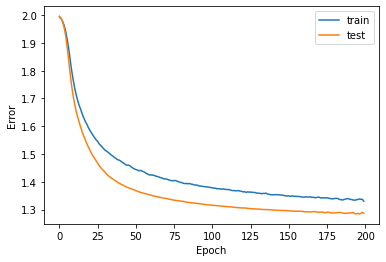

In [15]:
rbm10 = create_rbm(train_matrix, test_matrix, 1000, 10000, 200)

In [16]:
# torch.save(rbm10.state_dict(), "./ann-20-50-20-steam400-train0")

In [17]:
def compute_hr(train_matrix, test_matrix, rbm, k=10, batch_size=100):
    hitrates = []
    recall = []
    nDCG = []
    # for loop - go through every single user
    for id_user in tqdm(range(0, train_matrix.shape[0] - batch_size, batch_size)): # - batch_size, batch_size):
        v = train_matrix[id_user:id_user + batch_size]  # training set inputs are used to activate neurons of my RBM
        vt = test_matrix[id_user:id_user + batch_size]  # target
        if vt.getnnz() == 0:
            continue

        v = convert_sparse_matrix_to_sparse_tensor(v)
        vt = convert_sparse_matrix_to_sparse_tensor(vt)
        v = v.to_dense()
        vt = vt.to_dense()
        v = v.sub(1)
        vt = vt.sub(1)

        if torch.cuda.is_available():
            vt = vt.cuda()
            v = v.cuda()

        # ground truth
        users, movies = (vt > 1).nonzero(as_tuple=True)

        indices = torch.stack([users, movies])
        shape = (batch_size, train_matrix.shape[1])
        target = torch.sparse.LongTensor(indices, torch.add(vt[vt > 1].flatten(), 1), torch.Size(shape))
        target_dense = target.to_dense()

        target_rating, target_movie = torch.topk(target_dense, k, 1)
        # target_movie[target_rating < 3] = -1 # remove all bad movies from top k

        values, _ = torch.max(target_rating, dim=1)
        users_with_target = (values > 0).nonzero(as_tuple=True)[0].cpu().tolist()


        # predicted
        # _, h = rbm.sample_h(v)
        # recommended, _ = rbm.sample_v(h)
        recommended = rbm(v)
        recommended[v != -1] = -10
        predicted_rating, predicted_movie = torch.topk(recommended, k)

        # TODO optimize range s.t. users without target are skipped
        for user in users_with_target:

            # all recommendations
            user_target = target_movie[user][target_rating[user] > 0].cpu().tolist()
            user_pred = predicted_movie[user].cpu().tolist()

            counter = 0
            total = min(k, len(user_target))
            for target in user_target:
                if target in user_pred:
                    counter += 1
            # counter = len(recommendations)

            recall.append(counter / total)
            hitrates.append(min(1, counter))

            # nDCG
            idcg = np.sum([1 / np.log2(i+2) for i in range(min(k, len(user_target)))])
            dcg = 0
            for i, r in enumerate(user_pred):
                if r in user_target:
                    dcg += 1 / np.log2(i+2)

            nDCG.append(dcg / idcg) 

    return hitrates, recall, nDCG

hr

In [18]:
hr, r, ndcg = compute_hr(train_matrix, test_matrix, rbm10, k=10, batch_size=15000)

100%|██████████| 4/4 [00:10<00:00,  2.59s/it]


In [19]:
print(np.average(hr), np.average(r), np.average(ndcg))

0.44703643959134715 0.21272424730049744 0.13700630832122956


In [20]:
# rbm = RBM(n_vis, n_hidden)
# rbm.load_state_dict(torch.load("./network"))
# rbm.eval()